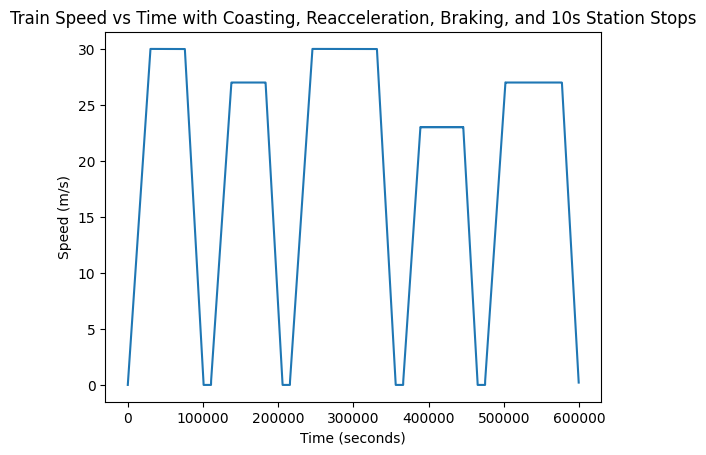

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def train_resistance(v, A, B, C, mass_train, curve_resistance, gradient_resistance):
    """
    Calculate the total train resistance, including straight-line resistance, curve resistance,
    and gradient resistance.
    """
    straight_line_resistance_per_ton = A + B * v + C * (v ** 2)
    straight_line_resistance = straight_line_resistance_per_ton * mass_train
    total_resistance = straight_line_resistance + curve_resistance + gradient_resistance
    return total_resistance

def calculate_curve_resistance(curve_radius, mass_train):
    """Calculate resistance due to curves."""
    if curve_radius == 0:
        return 0
    return (600 / curve_radius) * mass_train

def calculate_gradient_resistance(gradient_ratio, mass_train):
    """Calculate resistance due to gradients."""
    if gradient_ratio == 0:
        return 0
    mass_train_kg = mass_train * 1000
    g = 9.81
    return (mass_train_kg * g) / gradient_ratio

def power_required(total_resistance, speed):
    """Calculate the power required to overcome the total resistance."""
    return total_resistance * speed

def braking_distance(v, b):
    """Calculate the braking distance for a given speed."""
    return (v ** 2) / (2 * b)

def train_simulation_with_stops(distances, a, b, m, A, B, C, mass_train, curve_resistances, gradient_resistances, max_power, stop_time):
    """
    Simulate train journey with coasting, reacceleration, power considerations, and station stops.
    
    Arguments:
    - distances: List of distances between stations in meters.
    - a: Acceleration in m/s².
    - b: Braking in m/s².
    - m: Maximum speed in m/s.
    - A, B, C: Friction coefficients for resistance.
    - mass_train: Mass of the train in tons.
    - curve_resistances: List of curve resistances per section.
    - gradient_resistances: List of gradient resistances per section.
    - max_power: Maximum available power from the train's motor in Watts (W).
    - stop_time: Time in seconds to stop at each station.
    
    Returns:
    - speeds: List of speed vs time for plotting.
    """
    speeds = []
    delta_t = 0.001  # time step in seconds
    current_speed = 0
    coasting = False  # Indicates whether the train is in coasting mode
    stopped = False  # Whether the train is stopped at a station
    station_stop_counter = 0  # Counter for stopping duration

    for section_idx, distance in enumerate(distances):
        current_position = 0  # Reset for each station section
        
        while current_position < distance:
            # Get resistances for the current section
            curve_resistance = curve_resistances[section_idx]
            gradient_resistance = gradient_resistances[section_idx]

            # Calculate total resistance at current speed
            total_resistance = train_resistance(current_speed, A, B, C, mass_train, curve_resistance, gradient_resistance)

            # If train is stopped at a station
            if stopped:
                station_stop_counter += delta_t
                speeds.append(0)  # Speed is zero during stop
                if station_stop_counter >= stop_time:
                    stopped = False
                    station_stop_counter = 0  # Reset the stop counter
                continue

            # Braking phase: Check if the train should start braking
            distance_to_next_station = distance - current_position
            braking_dist = braking_distance(current_speed, b)
            
            if current_position < distance and braking_dist >= distance_to_next_station:
                # Start braking to stop at the station
                current_speed -= b * delta_t
                if current_speed < 0:
                    current_speed = 0
                speeds.append(current_speed)
                current_position += current_speed * delta_t
                continue

            # If no curve or gradient, we are coasting
            if curve_resistance == 0 and gradient_resistance == 0:
                coasting = True
            else:
                coasting = False

            if coasting:
                # During coasting, train slows down due to friction
                current_speed -= (total_resistance / (mass_train * 1000)) * delta_t

                # If speed drops below 90% of max speed, reapply acceleration
                if current_speed <= 0.9 * m:
                    coasting = False  # Stop coasting and reaccelerate
                    current_speed += a * delta_t
                    if current_speed > m:
                        current_speed = m
            else:
                # Calculate power required to maintain current speed
                power_needed = power_required(total_resistance, current_speed)

                if power_needed > max_power:
                    # If power needed exceeds available power, decelerate
                    current_speed -= b * delta_t
                    if current_speed < 0:
                        current_speed = 0
                elif current_speed < m:
                    # Reaccelerate if power allows and not yet at max speed
                    current_speed += a * delta_t
                    if current_speed > m:
                        current_speed = m

            # Update position and store speed
            current_position += current_speed * delta_t
            speeds.append(current_speed)

        # Simulate stop at station after finishing section
        stopped = True
        station_stop_counter = 0  # Start counting stop time at station

    return speeds

# Example inputs for the function
distances = [2200, 1900, 3400, 1800, 2700]  # Distances between stations in meters
a = 1  # Acceleration in m/s²
b = 1.2  # Braking in m/s²
m = 30  # Max speed in m/s
A, B, C = 10, 0.01, 0.0005  # Resistance coefficients
mass_train = 200  # Mass of train in tons
curve_resistances = [calculate_curve_resistance(200, mass_train), 0, calculate_curve_resistance(500, mass_train), 0, 0]
gradient_resistances = [0, 0, calculate_gradient_resistance(400, mass_train),  calculate_gradient_resistance(100, mass_train), 0]
max_power = 500000  # Max power available in Watts (500 kW)
stop_time = 10  # Stop at each station for 10 seconds

# Run simulation
speeds = train_simulation_with_stops(distances, a, b, m, A, B, C, mass_train, curve_resistances, gradient_resistances, max_power, stop_time)

# Plot the speed over time
plt.plot(speeds)
plt.xlabel('Time (seconds)')
plt.ylabel('Speed (m/s)')
plt.title('Train Speed vs Time with Coasting, Reacceleration, Braking, and 10s Station Stops')
plt.show()
